In [11]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
import keras
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
# Read the CSV file
data = pd.read_csv("R.csv")

In [12]:

labels = data.copy()

feature_headings = [
    "d1","d2","d3","d4","d5","d6","First Layer","Second Layer"
]

output_values = labels[feature_headings]
input_features = labels[[c for c in labels.columns if c not in feature_headings]]
label_encoder = LabelEncoder()

output_values["First Layer"] = label_encoder.fit_transform(output_values["First Layer"])
output_values["Second Layer"] = label_encoder.transform(output_values["Second Layer"])

unique_materials = pd.unique(data[['First Layer', 'Second Layer']].values.ravel())


num_materials = len(unique_materials)
num_wavelengths = 351

input_train, input_test, output_train, output_test = train_test_split(input_features, output_values, test_size=0.2, random_state=42)
input_train, input_val, output_train, output_val = train_test_split(input_train, output_train, test_size=0.2, random_state=42)

/tmp/ipykernel_38466/1402317043.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_values["First Layer"] = label_encoder.fit_transform(output_values["First Layer"])
/tmp/ipykernel_38466/1402317043.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_values["Second Layer"] = label_encoder.transform(output_values["Second Layer"])


In [13]:
i = Input(num_wavelengths,)

dl1 = Dense(num_wavelengths, activation="PReLU", input_shape=(num_wavelengths,))(i)

m1dl2 = Dense(256, activation="PReLU")(dl1)
m2dl2 = Dense(256, activation="PReLU")(dl1)
tdl2 = Dense(256, activation="PReLU")(dl1)

concatenated_input = Concatenate()([m1dl2, m2dl2, tdl2])

common_layer = Dense(500)(concatenated_input)

m1dl3 = Dense(128, activation="PReLU")(common_layer)
m2dl3 = Dense(128, activation="PReLU")(common_layer)
tdl3 = Dense(128, activation="PReLU")(common_layer)

out1 = Dense(num_materials, "softmax", name="first_layer")(m1dl3)
out2 = Dense(num_materials, "softmax", name="second_layer")(m2dl3)

material1 = Concatenate()([tdl3,out1])
material2 = Concatenate()([tdl3,out2])
t1 = Dense(1, "relu", name="t1")(material1)
t2 = Dense(1, "relu", name="t2")(material2)
t3 = Dense(1, "relu", name="t3")(material1)
t4 = Dense(1, "relu", name="t4")(material2)
t5 = Dense(1, "relu", name="t5")(material1)
t6 = Dense(1, "relu", name="t6")(material2)

classifier = Model(inputs=i, outputs=[out1,out2,t1,t2,t3,t4,t5,t6])
classifier.compile(
    optimizer="adam",
    loss={
        "first_layer": keras.losses.SparseCategoricalCrossentropy(),
        "second_layer": keras.losses.SparseCategoricalCrossentropy(),
        "t1": "mean_squared_error",
        "t2": "mean_squared_error",
        "t3": "mean_squared_error",
        "t4": "mean_squared_error",
        "t5": "mean_squared_error",
        "t6": "mean_squared_error",
    },
    metrics={
        "first_layer": tf.metrics.SparseCategoricalAccuracy("acc1"),
        "second_layer": tf.metrics.SparseCategoricalAccuracy("acc2"),
        "t1": "accuracy",
        "t2": "accuracy",
        "t3": "accuracy",
        "t4": "accuracy",
        "t5": "accuracy",
        "t6": "accuracy",
    }
)

In [14]:
classifier.fit(
    input_train,
    {
        "first_layer": output_train["First Layer"],
        "second_layer": output_train["Second Layer"],
        "t1": output_train["d1"],
        "t2": output_train["d2"],
        "t3": output_train["d3"],
        "t4": output_train["d4"],
        "t5": output_train["d5"],
        "t6": output_train["d6"],
    },
    epochs=10,
    validation_data=(
        input_val,
        {
            "first_layer": output_val["First Layer"],
            "second_layer": output_val["Second Layer"],
            "t1": output_val["d1"],
            "t2": output_val["d2"],
            "t3": output_val["d3"],
            "t4": output_val["d4"],
            "t5": output_val["d5"],
            "t6": output_val["d6"],
        }
    ),
    batch_size=32
)

Epoch 1/10
600/600 [==============================] - 18s 19ms/step - loss: 4403.2178 - first_layer_loss: 3.5819 - second_layer_loss: 3.6113 - t1_loss: 1522.1458 - t2_loss: 322.5903 - t3_loss: 323.9529 - t4_loss: 327.0513 - t5_loss: 378.1078 - t6_loss: 1522.1771 - first_layer_acc1: 0.0318 - second_layer_acc2: 0.0354 - t1_accuracy: 0.0000e+00 - t2_accuracy: 0.0000e+00 - t3_accuracy: 0.0000e+00 - t4_accuracy: 0.0000e+00 - t5_accuracy: 0.0000e+00 - t6_accuracy: 0.0000e+00 - val_loss: 4153.6860 - val_first_layer_loss: 3.4659 - val_second_layer_loss: 3.4612 - val_t1_loss: 1519.9375 - val_t2_loss: 282.8763 - val_t3_loss: 291.4599 - val_t4_loss: 279.0484 - val_t5_loss: 289.3952 - val_t6_loss: 1484.0416 - val_first_layer_acc1: 0.0325 - val_second_layer_acc2: 0.0452 - val_t1_accuracy: 0.0000e+00 - val_t2_accuracy: 0.0000e+00 - val_t3_accuracy: 0.0000e+00 - val_t4_accuracy: 0.0000e+00 - val_t5_accuracy: 0.0000e+00 - val_t6_accuracy: 0.0000e+00
Epoch 2/10
600/600 [==============================] 

In [15]:
index = random.randint(0, len(input_test) - 1)
input_sample = input_test.iloc[[index]]
output_sample = output_test.iloc[[index]]
mat_predict = classifier.predict([input_sample])
pred = label_encoder.inverse_transform([np.argmax(mat_predict[0]), np.argmax(mat_predict[1])])
act = label_encoder.inverse_transform([output_sample["First Layer"], output_sample["Second Layer"]])

print(f"model predicted: {pred}")
print(f"actual combination: {act}")

print(f"predicted_thicknesses: {[elem[0][0] for elem in mat_predict[2:]]}")
print(f"actual thicknesses: {output_sample.values[0][:6]}")

1/1 [==============================] - 0s 258ms/step
model predicted: ['Mn' 'Mg']
actual combination: ['Zn' 'Pt']
predicted_thicknesses: [0.0, 33.769066, 34.762447, 34.48763, 32.730476, 32.837414]
actual thicknesses: [20 20 50 60 20 40]


/root/repos/l2-transfer-matrix-method/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 167ms/step


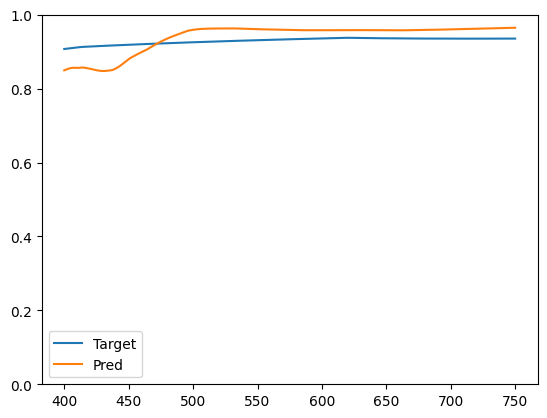

In [58]:
from tensorflow.keras.models import load_model
import pickle
model = load_model('savedmodel.h5')
#model.summary()
with open('encodersave', 'rb') as file:
    label_encoder = pickle.load(file)
# Select a random index from the test set
index = random.randint(0, len(input_test) - 1)


# Get the corresponding input and output values
input_sample = input_test.iloc[[index]]#target waveform
spec=classifier.predict(input_sample)#composition
thickness=np.array([elem[0][0] for elem in spec[2:]])#gets the thicknesses of composition
pred = label_encoder.inverse_transform([np.argmax(spec[0]), np.argmax(spec[1])])#gets names of materials
pred=label_encoder.transform(pred)#encodes using the forward model encoder 
combined =np.concatenate((thickness,pred))#puts in 1 array
spec_formated = pd.DataFrame([combined])#formats

# Make a prediction for the selected sample
forward_prediction = model.predict(spec_formated)


fig,ax = plt.subplots()
x = np.arange(400,751)
input_sample=np.squeeze(input_sample)
forward_prediction=np.squeeze(forward_prediction)
ax.plot(x, input_sample, label='Target')
ax.plot(x, forward_prediction, label='Pred')
ax.set_ylim(0,1)
ax.legend()
plt.show()

In [22]:
spec

[array([[0.00111848, 0.05180975, 0.01299311, 0.05956664, 0.02126317,
         0.0720773 , 0.01217214, 0.01741252, 0.06764165, 0.00279529,
         0.00065958, 0.05910622, 0.04410082, 0.00067866, 0.00066747,
         0.01869995, 0.01604226, 0.01751994, 0.06050008, 0.05631964,
         0.06952444, 0.05563816, 0.07124   , 0.00141588, 0.02698506,
         0.06793177, 0.00355967, 0.021431  , 0.01728657, 0.00254265,
         0.04935848, 0.01994162]], dtype=float32),
 array([[0.00364724, 0.05502025, 0.01484894, 0.06045962, 0.02973243,
         0.06050244, 0.02198785, 0.02816714, 0.05173533, 0.00769714,
         0.00322094, 0.06071056, 0.047117  , 0.00242046, 0.00338446,
         0.01428678, 0.01791894, 0.01961598, 0.05921105, 0.0538656 ,
         0.05304528, 0.05307585, 0.05475212, 0.00457461, 0.03085285,
         0.05745526, 0.01097198, 0.02399942, 0.01947174, 0.004141  ,
         0.04908688, 0.02302295]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[29.646677]], dtype=float32),
 

In [23]:
combined

array([0.0, 33.769065856933594, 34.762447357177734, 34.48762893676758,
       32.73047637939453, 32.8374137878418, 'Mn', 'Mg'], dtype=object)